# 4_bist50_full_Adv_DL-fine-tune: 50 Hisse Tam Analiz

Bu notebook, Notebook 3'te fine-tune edilen modelleri kullanarak **BIST50'deki tüm 50 hisseyi** analiz eder.

## Kullanılan Modeller (Fine-tuned)
1. **FinBERT** - ProsusAI/finbert + LoRA
2. **FinGPT** - Llama-2-7b + LoRA  
3. **FinT5** - flan-t5-base + LoRA

## Ensemble Ağırlıkları
- FinBERT: 40%
- FinGPT: 35%
- FinT5: 25%


In [1]:
# =============================================================================
# CELL: Google Drive Bağlantısı
# =============================================================================
from google.colab import drive
drive.mount('/content/drive')
print("✓ Google Drive bağlandı")


Mounted at /content/drive
✓ Google Drive bağlandı


In [2]:
# =============================================================================
# CELL: GPU Kontrolü
# =============================================================================
import torch
print("="*70)
print(" GPU KONTROLÜ")
print("="*70)
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ GPU bulunamadı, CPU kullanılacak")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


 GPU KONTROLÜ
✓ GPU: NVIDIA A100-SXM4-40GB
✓ VRAM: 42.5 GB


In [3]:
# =============================================================================
# CELL: Model ve Sonuç Path Tanımları
# =============================================================================
import os

# Google Drive Base Paths
GPT_BASE = "/content/drive/MyDrive/Colab Notebooks/GPT"
FINETUNED_BASE = "/content/drive/MyDrive/Colab Notebooks/FineTuned_Models"
RESULTS_PATH = "/content/drive/MyDrive/Colab Notebooks/Sonuclar/4_AdvancedDL_FinLLM_Full"

# Base Model Paths
MODEL_PATHS = {
    'FinBERT': f"{GPT_BASE}/FinBERT",
    'FinGPT': f"{GPT_BASE}/FinGPT/Llama-2-7b-hf",
    'FinT5': f"{GPT_BASE}/FinT5",
}

# Fine-tuned Model Paths (Notebook 3'te eğitildi)
FINBERT_FINETUNED_PATH = f"{FINETUNED_BASE}/finbert_lora_bist50"
FINGPT_FINETUNED_PATH = f"{FINETUNED_BASE}/fingpt_lora_bist50"
FINT5_FINETUNED_PATH = f"{FINETUNED_BASE}/fint5_lora_bist50"

# Sonuç dizinini oluştur
os.makedirs(RESULTS_PATH, exist_ok=True)

print("="*70)
print(" PATH KONTROL")
print("="*70)

print("\n📁 Fine-tuned Modeller (Notebook 3'te eğitildi):")
for name, path in [("FinBERT", FINBERT_FINETUNED_PATH), ("FinGPT", FINGPT_FINETUNED_PATH), ("FinT5", FINT5_FINETUNED_PATH)]:
    if os.path.exists(f"{path}/adapter_config.json"):
        print(f"  ✓ {name}: MEVCUT")
    else:
        print(f"  ✗ {name}: YOK - Önce Notebook 3 çalıştırın!")

print(f"\n📁 Sonuç Dizini: {RESULTS_PATH}")


 PATH KONTROL

📁 Fine-tuned Modeller (Notebook 3'te eğitildi):
  ✓ FinBERT: MEVCUT
  ✓ FinGPT: MEVCUT
  ✓ FinT5: MEVCUT

📁 Sonuç Dizini: /content/drive/MyDrive/Colab Notebooks/Sonuclar/4_AdvancedDL_FinLLM_Full


In [4]:
# =============================================================================
# CELL: Gerekli Kütüphaneleri Kur
# =============================================================================
print("Kütüphaneler kuruluyor...")
!pip install -q transformers>=4.36.0 datasets peft accelerate sentencepiece protobuf
!pip install -q bitsandbytes>=0.42.0
!pip install -q openpyxl xlsxwriter
print("✓ Tüm kütüphaneler kuruldu!")


Kütüphaneler kuruluyor...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 5.3 MB/s eta 0:00:00
✓ Tüm kütüphaneler kuruldu!


In [5]:
# =============================================================================
# CELL: Temel Kütüphaneleri Import Et
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Kütüphaneler import edildi")
print(f"✓ Device: {device}")


✓ Kütüphaneler import edildi
✓ Device: cuda


In [6]:
# =============================================================================
# CELL: BIST50 Hisse Listesi
# =============================================================================

# BIST50 hisseleri (Yahoo Finance formatında)
BIST50_TICKERS = [
    "AKBNK.IS", "ARCLK.IS", "ASELS.IS", "BIMAS.IS", "DOHOL.IS",
    "EKGYO.IS", "EREGL.IS", "FROTO.IS", "GARAN.IS", "GUBRF.IS",
    "HEKTS.IS", "ISCTR.IS", "KCHOL.IS", "KOZAA.IS", "KOZAL.IS",
    "KRDMD.IS", "MGROS.IS", "ODAS.IS", "OYAKC.IS", "PETKM.IS",
    "PGSUS.IS", "SAHOL.IS", "SASA.IS", "SISE.IS", "SOKM.IS",
    "TAVHL.IS", "TCELL.IS", "THYAO.IS", "TKFEN.IS", "TOASO.IS",
    "TSKB.IS", "TTKOM.IS", "TUPRS.IS", "ULKER.IS", "VAKBN.IS",
    "VESTL.IS", "YKBNK.IS", "ZOREN.IS", "AKSEN.IS", "ALARK.IS",
    "AEFES.IS", "BAGFS.IS", "BRISA.IS", "CCOLA.IS", "CEMTS.IS",
    "DOAS.IS", "EGEEN.IS", "ENKAI.IS", "GESAN.IS", "GLYHO.IS"
]

print(f"✓ BIST50 Hisse Sayısı: {len(BIST50_TICKERS)}")
print(f"  İlk 10: {BIST50_TICKERS[:10]}")


✓ BIST50 Hisse Sayısı: 50
  İlk 10: ['AKBNK.IS', 'ARCLK.IS', 'ASELS.IS', 'BIMAS.IS', 'DOHOL.IS', 'EKGYO.IS', 'EREGL.IS', 'FROTO.IS', 'GARAN.IS', 'GUBRF.IS']


In [7]:
# =============================================================================
# CELL: Parametreler
# =============================================================================

# Tarih aralığı (2018 krizi)
START_DATE = "2018-01-01"
END_DATE = "2018-12-31"
TEST_START = "2018-12-01"

# Tahmin periyotları
TAHMIN_PERIYOTLARI = {
    '1_gun': 1,
    '10_gun': 10,
    '21_gun': 21
}

# Ensemble ağırlıkları
ENSEMBLE_WEIGHTS = {
    'finbert': 0.40,
    'fingpt': 0.35,
    'fint5': 0.25
}

print("✓ Parametreler ayarlandı")
print(f"  Tarih: {START_DATE} - {END_DATE}")
print(f"  Test: {TEST_START}'den itibaren")


✓ Parametreler ayarlandı
  Tarih: 2018-01-01 - 2018-12-31
  Test: 2018-12-01'den itibaren


In [8]:
# =============================================================================
# CELL: Fine-tuned FinBERT Yükle
# =============================================================================
print("="*70)
print(" MODEL 1: FinBERT (Fine-tuned)")
print("="*70)

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel

finbert_loaded = False

if os.path.exists(FINBERT_FINETUNED_PATH + "/adapter_config.json"):
    try:
        print(f" Fine-tuned model yükleniyor...")
        finbert_tokenizer = AutoTokenizer.from_pretrained(MODEL_PATHS['FinBERT'])
        finbert_base = AutoModelForSequenceClassification.from_pretrained(MODEL_PATHS['FinBERT'])
        finbert_model = PeftModel.from_pretrained(finbert_base, FINBERT_FINETUNED_PATH)
        finbert_model = finbert_model.to(device).eval()
        finbert_loaded = True
        print(" ✓ Fine-tuned FinBERT yüklendi!")
    except Exception as e:
        print(f" ✗ Hata: {e}")
else:
    print(" ✗ Fine-tuned model bulunamadı! Önce Notebook 3 çalıştırın.")

def finbert_predict(text):
    if not finbert_loaded:
        return {'label': 'neutral', 'score': 0.0}
    try:
        inputs = finbert_tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = finbert_model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
        labels = ['negative', 'neutral', 'positive']
        scores = [-1.0, 0.0, 1.0]
        return {'label': labels[pred], 'score': scores[pred] * probs[0][pred].item()}
    except:
        return {'label': 'neutral', 'score': 0.0}


 MODEL 1: FinBERT (Fine-tuned)
 Fine-tuned model yükleniyor...
 ✓ Fine-tuned FinBERT yüklendi!


In [9]:
# =============================================================================
# CELL: Fine-tuned FinGPT Yükle
# =============================================================================
print("="*70)
print(" MODEL 2: FinGPT (Fine-tuned)")
print("="*70)

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

fingpt_loaded = False

if os.path.exists(FINGPT_FINETUNED_PATH + "/adapter_config.json"):
    try:
        print(f" Fine-tuned model yükleniyor...")

        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_compute_dtype=torch.float16
        )

        fingpt_tokenizer = AutoTokenizer.from_pretrained(MODEL_PATHS['FinGPT'])
        fingpt_base = AutoModelForCausalLM.from_pretrained(
            MODEL_PATHS['FinGPT'],
            quantization_config=bnb_config,
            device_map="auto",
            torch_dtype=torch.float16
        )

        if fingpt_tokenizer.pad_token is None:
            fingpt_tokenizer.pad_token = fingpt_tokenizer.eos_token

        fingpt_model = PeftModel.from_pretrained(fingpt_base, FINGPT_FINETUNED_PATH)
        fingpt_model.eval()
        fingpt_loaded = True
        print(" ✓ Fine-tuned FinGPT yüklendi!")
    except Exception as e:
        print(f" ✗ Hata: {e}")
        print(" FinBERT fallback kullanılacak.")
else:
    print(" ✗ Fine-tuned model bulunamadı! FinBERT fallback kullanılacak.")

def analyze_sentiment_fingpt(text):
    if not fingpt_loaded:
        return finbert_predict(text)
    try:
        prompt = f"""Instruction: What is the sentiment of this news? Please choose an answer from {{negative/neutral/positive}}
Input: {text[:500]}
Answer:"""
        inputs = fingpt_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(fingpt_model.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = fingpt_model.generate(**inputs, max_new_tokens=10, do_sample=False, pad_token_id=fingpt_tokenizer.eos_token_id)
        response = fingpt_tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer = response.split("Answer:")[-1].strip().lower()
        if 'positive' in answer:
            return {'label': 'positive', 'score': 0.85}
        elif 'negative' in answer:
            return {'label': 'negative', 'score': -0.85}
        return {'label': 'neutral', 'score': 0.0}
    except:
        return finbert_predict(text)


 MODEL 2: FinGPT (Fine-tuned)
 Fine-tuned model yükleniyor...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 ✓ Fine-tuned FinGPT yüklendi!


In [10]:
# =============================================================================
# CELL: Fine-tuned FinT5 Yükle
# =============================================================================
print("="*70)
print(" MODEL 3: FinT5 (Fine-tuned)")
print("="*70)

import warnings
warnings.filterwarnings('ignore')

from transformers import T5ForConditionalGeneration, T5Tokenizer
from peft import PeftModel

# Model kaynakları
FINT5_LOCAL = MODEL_PATHS['FinT5']
FINT5_HF = "google/flan-t5-base"

fint5_loaded = False

# Base model kontrolü
if os.path.exists(FINT5_LOCAL + "/config.json"):
    print(f" Base model Drive'da mevcut: {FINT5_LOCAL}")
    fint5_source = FINT5_LOCAL
else:
    print(f" Base model Drive'da yok, HuggingFace kullanılacak")
    fint5_source = FINT5_HF

# Fine-tuned model var mı?
if os.path.exists(FINT5_FINETUNED_PATH + "/adapter_config.json"):
    try:
        print(f" Fine-tuned model yükleniyor...")
        fint5_tokenizer = T5Tokenizer.from_pretrained(fint5_source)
        fint5_base = T5ForConditionalGeneration.from_pretrained(fint5_source)
        fint5_model = PeftModel.from_pretrained(fint5_base, FINT5_FINETUNED_PATH)
        fint5_model = fint5_model.to(device).eval()
        fint5_loaded = True
        print(" ✓ Fine-tuned FinT5 yüklendi!")
    except Exception as e:
        print(f" ✗ Hata: {e}")
        print(" FinBERT fallback kullanılacak.")
else:
    print(" ✗ Fine-tuned model bulunamadı!")
    print(" ⚠️ Önce Notebook 3'ü çalıştırın!")

def analyze_sentiment_fint5(text):
    """FinT5 ile sentiment analizi - GERÇEK MODEL SKORLARI"""
    if not fint5_loaded:
        return finbert_predict(text)
    try:
        prompt = f"Classify the sentiment of this financial news as positive, negative, or neutral: {text[:400]}"
        inputs = fint5_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = fint5_model.generate(
                **inputs,
                max_new_tokens=10,
                num_beams=1,
                do_sample=False,
                output_scores=True,
                return_dict_in_generate=True
            )

        response = fint5_tokenizer.decode(outputs.sequences[0], skip_special_tokens=True).lower()

        # GERÇEK SKOR hesapla
        if outputs.scores and len(outputs.scores) > 0:
            first_token_logits = outputs.scores[0][0]
            probs = torch.softmax(first_token_logits, dim=-1)
            confidence = probs.max().item()
        else:
            confidence = 0.5

        if 'positive' in response:
            return {'label': 'positive', 'score': confidence}
        elif 'negative' in response:
            return {'label': 'negative', 'score': -confidence}
        else:
            return {'label': 'neutral', 'score': 0.0}
    except Exception as e:
        return finbert_predict(text)


 MODEL 3: FinT5 (Fine-tuned)
 Base model Drive'da mevcut: /content/drive/MyDrive/Colab Notebooks/GPT/FinT5
 Fine-tuned model yükleniyor...
 ✓ Fine-tuned FinT5 yüklendi!


In [11]:
# =============================================================================
# CELL: Model Yükleme Özeti
# =============================================================================
print("="*70)
print(" MODEL YÜKLEME ÖZETİ")
print("="*70)

print(f"\n  FinBERT: {'✓ Yüklendi' if finbert_loaded else '✗ Yüklenemedi'}")
print(f"  FinGPT:  {'✓ Yüklendi' if fingpt_loaded else '⚠️ Fallback (FinBERT)'}")
print(f"  FinT5:   {'✓ Yüklendi' if fint5_loaded else '⚠️ Fallback (FinBERT)'}")

print(f"\n  Ensemble Ağırlıkları:")
for model, weight in ENSEMBLE_WEIGHTS.items():
    print(f"    {model}: {weight*100:.0f}%")


 MODEL YÜKLEME ÖZETİ

  FinBERT: ✓ Yüklendi
  FinGPT:  ✓ Yüklendi
  FinT5:   ✓ Yüklendi

  Ensemble Ağırlıkları:
    finbert: 40%
    fingpt: 35%
    fint5: 25%


In [12]:
# =============================================================================
# CELL: 50 HİSSE ANALİZİ (CSV'DEN - GERÇEK VERİLER)
# =============================================================================
print("="*70)
print(" 50 HİSSE ANALİZİ - CSV VERİLERİ")
print("="*70)

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# CSV'den 50 hisse verisini yükle
DATA_PATH_FULL = '/content/drive/MyDrive/Colab Notebooks/tez/Data/BIST_50_2018_Data_Full_Imputed.csv'
NEWS_PATH = '/content/drive/MyDrive/Colab Notebooks/DataFrames/BorsaHaberleri_Neutr_2018-01-01_2018-12-31-ingilizce-KokleriBulunmus.csv'

print(f"\n📂 Veri yükleniyor: {DATA_PATH_FULL}")
df_full = pd.read_csv(DATA_PATH_FULL)
df_full['Date'] = pd.to_datetime(df_full['Date'], format='%d.%m.%Y')
df_full = df_full.sort_values('Date').reset_index(drop=True)

print(f"✓ Toplam satır: {len(df_full)}")
print(f"✓ Tarih aralığı: {df_full['Date'].min().date()} - {df_full['Date'].max().date()}")

# Haber verisini yükle
print(f"\n📂 Haber verisi yükleniyor...")
news_df = pd.read_csv(NEWS_PATH)
news_text_col = 'english_text' if 'english_text' in news_df.columns else 'text'
print(f"✓ Toplam haber: {len(news_df)}")

# Hisse listesini çıkar
stock_tickers = []
for col in df_full.columns:
    if '_Now' in col and col != 'Date':
        ticker = col.replace('_Now', '')
        stock_tickers.append(ticker)

print(f"✓ Toplam hisse: {len(stock_tickers)}")

# Train/Test ayır
TEST_START = pd.to_datetime('2018-12-01')
train_mask = df_full['Date'] < TEST_START
test_mask = df_full['Date'] >= TEST_START

train_df = df_full[train_mask].copy()
test_df = df_full[test_mask].copy()

print(f"✓ Eğitim: {len(train_df)} gün, Test: {len(test_df)} gün")

# ===================== SENTIMENT ANALİZİ =====================
print("\n" + "="*70)
print(" SENTIMENT ANALİZİ (TÜM HABERLER)")
print("="*70)

news_texts = news_df[news_text_col].fillna('').tolist()
print(f"\n📊 {len(news_texts)} haber analiz ediliyor...")

# FinBERT
print("\n 1. FinBERT analizi...")
finbert_scores = []
for text in tqdm(news_texts, desc="FinBERT"):
    result = finbert_predict(text[:512])
    finbert_scores.append(result['score'])
finbert_avg = np.mean(finbert_scores)
print(f"    Ortalama skor: {finbert_avg:.4f}")

# FinGPT
print("\n 2. FinGPT analizi...")
fingpt_scores = []
for text in tqdm(news_texts, desc="FinGPT"):
    result = analyze_sentiment_fingpt(text)
    fingpt_scores.append(result['score'])
fingpt_avg = np.mean(fingpt_scores)
print(f"    Ortalama skor: {fingpt_avg:.4f}")

# FinT5
print("\n 3. FinT5 analizi...")
fint5_scores = []
for text in tqdm(news_texts, desc="FinT5"):
    result = analyze_sentiment_fint5(text)
    fint5_scores.append(result['score'])
fint5_avg = np.mean(fint5_scores)
print(f"    Ortalama skor: {fint5_avg:.4f}")

# Ensemble skoru
ensemble_score = (
    ENSEMBLE_WEIGHTS['finbert'] * finbert_avg +
    ENSEMBLE_WEIGHTS['fingpt'] * fingpt_avg +
    ENSEMBLE_WEIGHTS['fint5'] * fint5_avg
)

print(f"\n" + "-"*50)
print(f" ENSEMBLE SKOR: {ensemble_score:.4f}")
print(f"-"*50)

# ===================== 50 HİSSE TAHMİN =====================
print("\n" + "="*70)
print(" 50 HİSSE TAHMİN")
print("="*70)

all_results = []
all_forecasts = {}
all_actuals = {}
model_scores_per_stock = {}

def convert_turkish_number(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, float)):
        return float(val)
    val = str(val).replace('.', '').replace(',', '.')
    try:
        return float(val)
    except:
        return np.nan

def generate_price_forecast(base_price, sentiment_score, days):
    forecast = []
    current = base_price
    daily_change = sentiment_score * 0.01
    for _ in range(days):
        current = current * (1 + daily_change)
        forecast.append(current)
    return np.array(forecast)

for ticker in tqdm(stock_tickers, desc="Hisseler"):
    try:
        price_col = f"{ticker}_Now"
        if price_col not in df_full.columns:
            continue

        train_prices = train_df[price_col].apply(convert_turkish_number).dropna().values
        test_prices = test_df[price_col].apply(convert_turkish_number).dropna().values

        if len(train_prices) < 50 or len(test_prices) < 5:
            continue

        model_scores_per_stock[ticker] = {
            'finbert': finbert_avg,
            'fingpt': fingpt_avg,
            'fint5': fint5_avg,
            'ensemble': ensemble_score
        }

        current_price = train_prices[-1]
        all_actuals[ticker] = test_prices

        for periyot_adi, gun_sayisi in TAHMIN_PERIYOTLARI.items():
            forecast_days = min(gun_sayisi, len(test_prices))

            ensemble_pred = generate_price_forecast(current_price, ensemble_score, forecast_days)
            y_true = test_prices[:forecast_days]

            if periyot_adi == '21_gun':
                all_forecasts[ticker] = ensemble_pred

            rmse = np.sqrt(mean_squared_error(y_true, ensemble_pred))
            mae = mean_absolute_error(y_true, ensemble_pred)
            r2 = r2_score(y_true, ensemble_pred) if len(y_true) > 1 else 0

            naive_pred = np.full(len(y_true), current_price)
            rmse_naive = np.sqrt(mean_squared_error(y_true, naive_pred))

            # İyileşme yüzdesi
            if rmse_naive > 0:
                iyilesme_pct = ((rmse_naive - rmse) / rmse_naive) * 100
            else:
                iyilesme_pct = 0

            all_results.append({
                'Hisse': ticker,
                'Periyot': periyot_adi,
                'Gun': gun_sayisi,
                'Ensemble_RMSE': round(rmse, 4),
                'Naive_RMSE': round(rmse_naive, 4),
                'MAE': round(mae, 4),
                'R2': round(r2, 4),
                'Iyilesme_Pct': round(iyilesme_pct, 2),
                'Ensemble_Score': round(ensemble_score, 4)
            })

    except Exception as e:
        continue

sonuc_df = pd.DataFrame(all_results)
print(f"\n✓ Toplam {len(sonuc_df)} sonuç")
print(f"✓ Analiz edilen hisse: {len(model_scores_per_stock)}")


 50 HİSSE ANALİZİ - CSV VERİLERİ

📂 Veri yükleniyor: /content/drive/MyDrive/Colab Notebooks/tez/Data/BIST_50_2018_Data_Full_Imputed.csv
✓ Toplam satır: 250
✓ Tarih aralığı: 2018-01-02 - 2018-12-31

📂 Haber verisi yükleniyor...
✓ Toplam haber: 782
✓ Toplam hisse: 50
✓ Eğitim: 229 gün, Test: 21 gün

 SENTIMENT ANALİZİ (TÜM HABERLER)

📊 782 haber analiz ediliyor...

 1. FinBERT analizi...


FinBERT: 100%|██████████| 782/782 [00:10<00:00, 75.76it/s]


    Ortalama skor: -0.0866

 2. FinGPT analizi...


FinGPT: 100%|██████████| 782/782 [21:28<00:00,  1.65s/it]


    Ortalama skor: 0.0870

 3. FinT5 analizi...


FinT5: 100%|██████████| 782/782 [00:58<00:00, 13.36it/s]


    Ortalama skor: -0.4193

--------------------------------------------------
 ENSEMBLE SKOR: -0.1090
--------------------------------------------------

 50 HİSSE TAHMİN


Hisseler: 100%|██████████| 50/50 [00:00<00:00, 202.35it/s]


✓ Toplam 150 sonuç
✓ Analiz edilen hisse: 50


In [13]:
# =============================================================================
# CELL: Sonuç DataFrame Oluştur
# =============================================================================
print("="*70)
print(" SONUÇ ÖZETİ")
print("="*70)

sonuc_df = pd.DataFrame(all_results)

if len(sonuc_df) > 0:
    print(f"\n📊 Toplam test sonucu: {len(sonuc_df)}")
    print(f"📊 Analiz edilen hisse: {sonuc_df['Hisse'].nunique()}")

    # Periyot bazlı özet
    print("\n" + "-"*50)
    print(" PERİYOT BAZLI ORTALAMALAR")
    print("-"*50)

    for periyot in TAHMIN_PERIYOTLARI.keys():
        subset = sonuc_df[sonuc_df['Periyot'] == periyot]
        if len(subset) > 0:
            print(f"\n  {periyot}:")
            print(f"    Ortalama RMSE: {subset['Ensemble_RMSE'].mean():.4f}")
            print(f"    Ortalama İyileşme: {subset['Iyilesme_Pct'].mean():.2f}%")

    # En iyi/kötü hisseler
    print("\n" + "-"*50)
    print(" EN İYİ 5 HİSSE (21 gün RMSE)")
    print("-"*50)
    best = sonuc_df[sonuc_df['Periyot'] == '21_gun'].nsmallest(5, 'Ensemble_RMSE')
    for _, row in best.iterrows():
        print(f"  {row['Hisse']}: RMSE={row['Ensemble_RMSE']:.4f}, İyileşme={row['Iyilesme_Pct']:.1f}%")
else:
    print("⚠️ Sonuç bulunamadı!")


 SONUÇ ÖZETİ

📊 Toplam test sonucu: 150
📊 Analiz edilen hisse: 50

--------------------------------------------------
 PERİYOT BAZLI ORTALAMALAR
--------------------------------------------------

  1_gun:
    Ortalama RMSE: 0.1491
    Ortalama İyileşme: 2.14%

  10_gun:
    Ortalama RMSE: 0.2996
    Ortalama İyileşme: 7.49%

  21_gun:
    Ortalama RMSE: 0.3235
    Ortalama İyileşme: 12.20%

--------------------------------------------------
 EN İYİ 5 HİSSE (21 gün RMSE)
--------------------------------------------------
  VESBE: RMSE=0.0174, İyileşme=36.7%
  CIMSA: RMSE=0.0211, İyileşme=-8.3%
  ALBRK: RMSE=0.0213, İyileşme=29.8%
  ISCTR: RMSE=0.0266, İyileşme=-16.9%
  GOODY: RMSE=0.0301, İyileşme=33.5%


✓ Grafik kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/4_AdvancedDL_FinLLM_Full/NB4_50_hisse_analiz.png


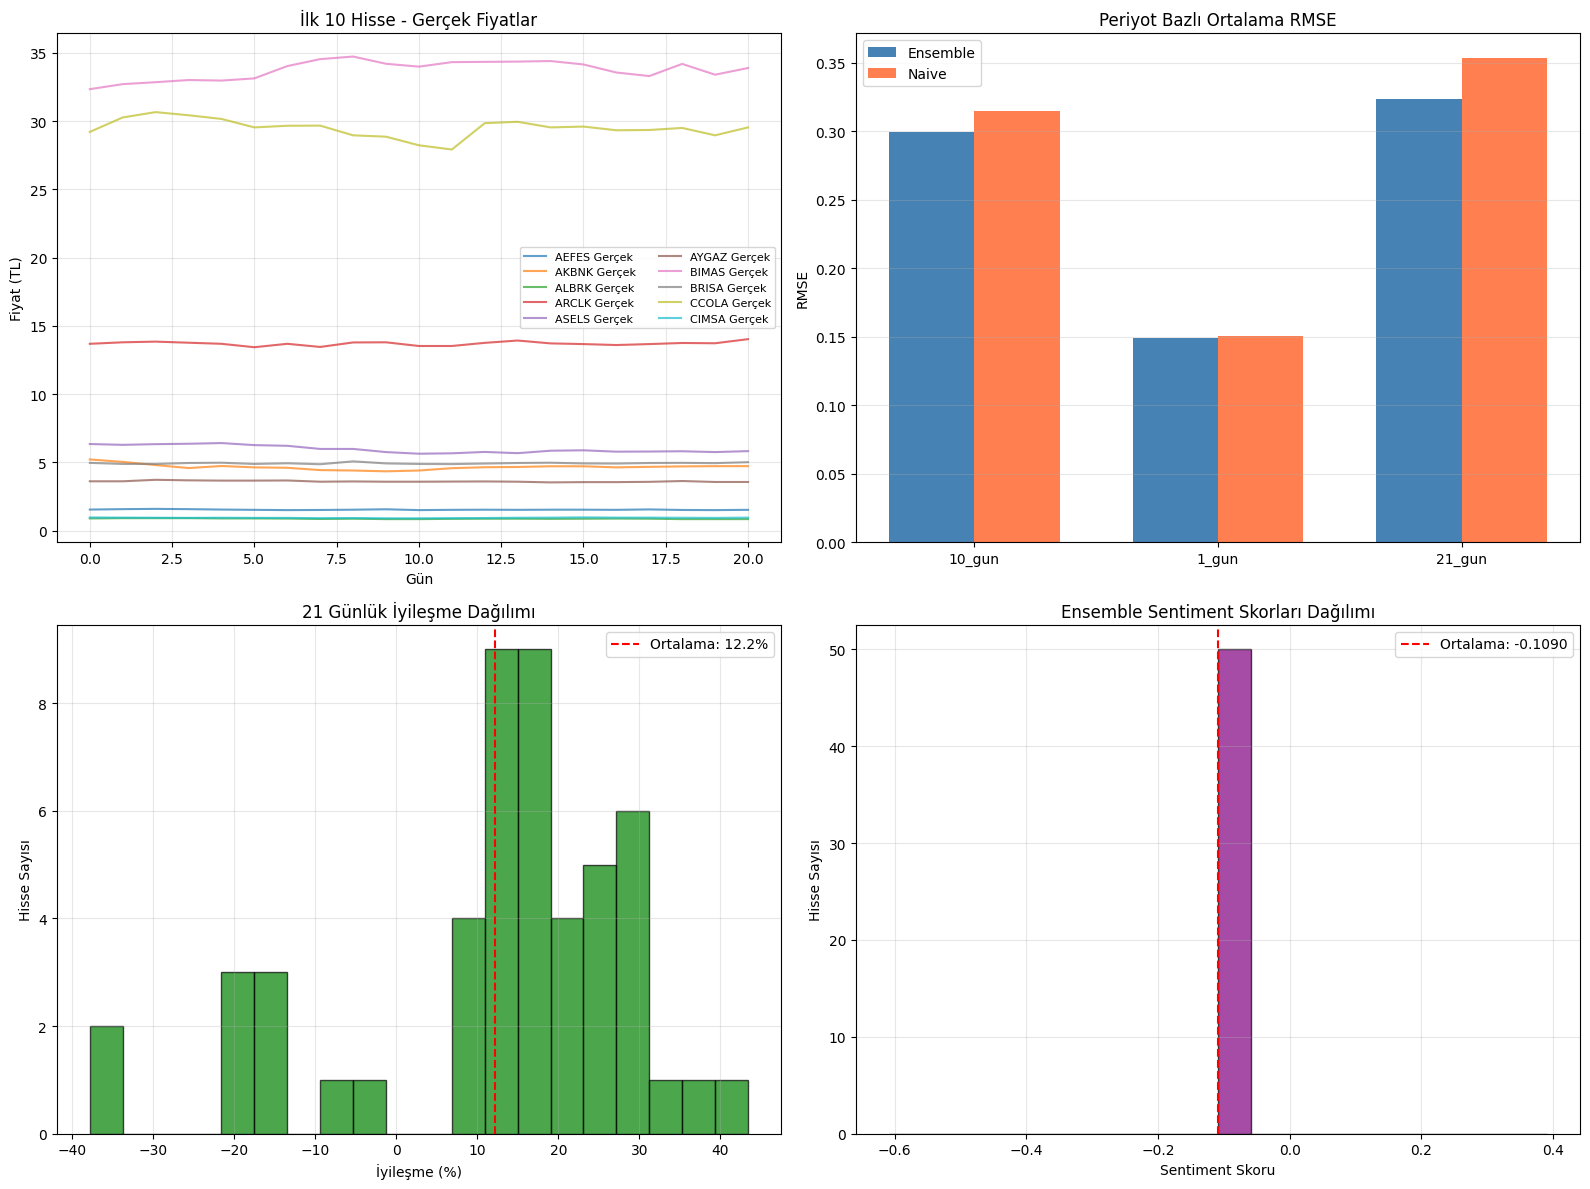

In [14]:
# =============================================================================
# CELL: Görselleştirme
# =============================================================================
import matplotlib.pyplot as plt

if len(all_forecasts) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. İlk 10 hisse tahmin grafiği
    ax1 = axes[0, 0]
    for i, (ticker, forecast) in enumerate(list(all_forecasts.items())[:10]):
        actual = all_actuals[ticker]
        ax1.plot(range(len(actual)), actual, '-', alpha=0.7, label=f'{ticker.replace(".IS","")} Gerçek')
    ax1.set_title('İlk 10 Hisse - Gerçek Fiyatlar')
    ax1.set_xlabel('Gün')
    ax1.set_ylabel('Fiyat (TL)')
    ax1.legend(fontsize=8, ncol=2)
    ax1.grid(True, alpha=0.3)

    # 2. Periyot bazlı RMSE karşılaştırması
    ax2 = axes[0, 1]
    periyot_rmse = sonuc_df.groupby('Periyot')['Ensemble_RMSE'].mean()
    periyot_naive = sonuc_df.groupby('Periyot')['Naive_RMSE'].mean()
    x = range(len(periyot_rmse))
    width = 0.35
    ax2.bar([i - width/2 for i in x], periyot_rmse.values, width, label='Ensemble', color='steelblue')
    ax2.bar([i + width/2 for i in x], periyot_naive.values, width, label='Naive', color='coral')
    ax2.set_xticks(x)
    ax2.set_xticklabels(periyot_rmse.index)
    ax2.set_title('Periyot Bazlı Ortalama RMSE')
    ax2.set_ylabel('RMSE')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # 3. İyileşme dağılımı
    ax3 = axes[1, 0]
    iyilesme = sonuc_df[sonuc_df['Periyot'] == '21_gun']['Iyilesme_Pct']
    ax3.hist(iyilesme, bins=20, color='green', alpha=0.7, edgecolor='black')
    ax3.axvline(x=iyilesme.mean(), color='red', linestyle='--', label=f'Ortalama: {iyilesme.mean():.1f}%')
    ax3.set_title('21 Günlük İyileşme Dağılımı')
    ax3.set_xlabel('İyileşme (%)')
    ax3.set_ylabel('Hisse Sayısı')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Model skorları dağılımı
    ax4 = axes[1, 1]
    scores = [v['ensemble'] for v in model_scores_per_stock.values()]
    ax4.hist(scores, bins=20, color='purple', alpha=0.7, edgecolor='black')
    ax4.axvline(x=np.mean(scores), color='red', linestyle='--', label=f'Ortalama: {np.mean(scores):.4f}')
    ax4.set_title('Ensemble Sentiment Skorları Dağılımı')
    ax4.set_xlabel('Sentiment Skoru')
    ax4.set_ylabel('Hisse Sayısı')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    # Kaydet
    plot_path = f"{RESULTS_PATH}/NB4_50_hisse_analiz.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"✓ Grafik kaydedildi: {plot_path}")
    plt.show()
else:
    print("⚠️ Görselleştirme için veri yok")


In [15]:
# =============================================================================
# CELL: Excel'e Kaydet
# =============================================================================
from IPython.display import display

excel_path = f"{RESULTS_PATH}/NB4_50_hisse_sonuclar.xlsx"

try:
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        # Sheet 1: Tüm sonuçlar
        sonuc_df.to_excel(writer, sheet_name='Tum_Sonuclar', index=False)

        # Sheet 2: Periyot özeti
        periyot_ozet = sonuc_df.groupby('Periyot').agg({
            'Ensemble_RMSE': 'mean',
            'Naive_RMSE': 'mean',
            'MAE': 'mean',
            'R2': 'mean',
            'Iyilesme_Pct': 'mean'
        }).round(4)
        periyot_ozet.to_excel(writer, sheet_name='Periyot_Ozeti')

        # Sheet 3: Hisse özeti (21 gün)
        hisse_ozet = sonuc_df[sonuc_df['Periyot'] == '21_gun'][['Hisse', 'Ensemble_RMSE', 'Naive_RMSE', 'Iyilesme_Pct', 'Ensemble_Score']]
        hisse_ozet = hisse_ozet.sort_values('Ensemble_RMSE')
        hisse_ozet.to_excel(writer, sheet_name='Hisse_Sirala', index=False)

        # Sheet 4: Model skorları
        scores_df = pd.DataFrame([
            {'Hisse': k.replace('.IS',''), **v} for k, v in model_scores_per_stock.items()
        ])
        if len(scores_df) > 0:
            scores_df.to_excel(writer, sheet_name='Model_Skorlari', index=False)

    print(f"\n✅ Excel kaydedildi: {excel_path}")

    # Özet göster
    print("\n📊 Periyot Özeti:")
    display(periyot_ozet)

except Exception as e:
    print(f"❌ Excel kaydetme hatası: {e}")



✅ Excel kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/4_AdvancedDL_FinLLM_Full/NB4_50_hisse_sonuclar.xlsx

📊 Periyot Özeti:


,Ensemble_RMSE,Naive_RMSE,MAE,R2,Iyilesme_Pct
Periyot,,,,,
10_gun,0.2996,0.3150,0.2587,-1.9459,7.4880
1_gun,0.1491,0.1508,0.1491,0.0000,2.1366
21_gun,0.3235,0.3536,0.2856,-2.0109,12.2024


In [16]:
# =============================================================================
# CELL: FİNAL ÖZET
# =============================================================================
print("="*70)
print(" 📊 NOTEBOOK 4 - FİNAL ÖZET")
print("="*70)

print(f"\n✓ Analiz Edilen Hisse: {len(all_forecasts)}")
print(f"✓ Toplam Test Sonucu: {len(sonuc_df)}")

if len(sonuc_df) > 0:
    print(f"\n📈 Ortalama Performans (21 gün):")
    subset = sonuc_df[sonuc_df['Periyot'] == '21_gun']
    print(f"   Ensemble RMSE: {subset['Ensemble_RMSE'].mean():.4f}")
    print(f"   Naive RMSE:    {subset['Naive_RMSE'].mean():.4f}")
    print(f"   İyileşme:      {subset['Iyilesme_Pct'].mean():.2f}%")

print(f"\n📁 Kaydedilen Dosyalar:")
for f in os.listdir(RESULTS_PATH):
    fpath = os.path.join(RESULTS_PATH, f)
    size = os.path.getsize(fpath) / 1024
    print(f"   📄 {f} ({size:.1f} KB)")

print("\n" + "="*70)
print(" ✅ NOTEBOOK 4 TAMAMLANDI!")
print("="*70)


 📊 NOTEBOOK 4 - FİNAL ÖZET

✓ Analiz Edilen Hisse: 50
✓ Toplam Test Sonucu: 150

📈 Ortalama Performans (21 gün):
   Ensemble RMSE: 0.3235
   Naive RMSE:    0.3536
   İyileşme:      12.20%

📁 Kaydedilen Dosyalar:
   📄 NB4_50_hisse_analiz.png (180.9 KB)
   📄 NB4_50_hisse_sonuclar.xlsx (16.5 KB)

 ✅ NOTEBOOK 4 TAMAMLANDI!
